In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_csv_data = pd.read_csv('./input/013 IndexE8.csv')
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index('date', inplace=True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value'] = df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df,df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### LLR Test

In [5]:
# DF: degree of freedom
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf # extracts Log-Lielihood
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1)) # compute test statistics
    p = chi2.sf(LR, DF).round(3) # calculate p-value
    return p

### The DF-Test

In [10]:
sts.adfuller(df.market_value)

(-1.9041551418836906,
 0.3301089327702812,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

<b>H0</b>: the data came from non-stationary proccess

p-val (0.33) > 0.05 ==> we cant say the data came from stationary proccess

we cant reject the null hypothesis

<b>It is mean that we shouldnt rely on AR models to make accurate forecasts<b/>

### Using Returns

In [13]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

In [14]:
sts.adfuller(df.returns)

(-12.770265719497393,
 7.798058336032513e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

<b>7.7e-24 < 0.05 ==> the data came from stationary proccesss</b>
    
    
<b>t-statistics -12.7 < 1%: -3.4</b> ==> we can confidently say that the data came froms tationary proccess

### ACF and PACF for returns

Text(0.5, 1.0, 'ACF FTSE Returns')

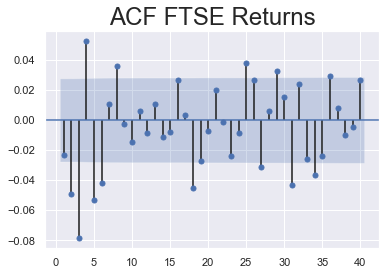

In [15]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.title("ACF FTSE Returns", size = 24)

Text(0.5, 1.0, 'PACF FTSE Returns')

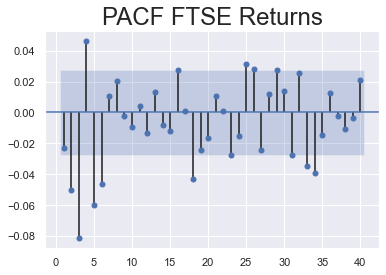

In [16]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size = 24)

* One way to interprent the graphs is the prices of today often move of the opposites direction of the prices yesterday 

### AR(1) for Returns

In [17]:
model_ret_ar_1 = ARMA(df.returns, order =(0,1))

In [18]:
results_ret_ar_1 = model_ret_ar_1.fit()

In [19]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sun, 10 May 2020   AIC                          15865.190
Time:                        10:22:37   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8549           +0.0000j           38.8549            0.0000
-----------------------------------------------------------------------------
"""

P>|z| Neither is significantly different from zero (both > 0.05 so we cant reject null hypothesis)

This model holds no real predictive power

### Higher-Lag AR Models for Returns

In [21]:
model_ret_ar_2 = ARMA(df.returns, order = (2,0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood               -7923.456
Method:                       css-mle   S.D. of innovations              1.173
Date:                Sun, 10 May 2020   AIC                          15854.911
Time:                        10:27:13   BIC                          15880.996
Sample:                    01-10-1994   HQIC                         15864.052
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.220      0.222      -0.011       0.049
ar.L1.returns    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.returns    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [22]:
LLR_test(model_ret_ar_1,model_ret_ar_2)

0.0

0.0 < 1% ==> the new model better then previous one

+

All Three criteries lower then previous model

<b>AR(2) is a better model then AR(1)</b>

In [23]:
model_ret_ar_3 = ARMA(df.returns, order = (3,0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(3, 0)   Log Likelihood               -7906.738
Method:                       css-mle   S.D. of innovations              1.169
Date:                Sun, 10 May 2020   AIC                          15823.477
Time:                        10:57:19   BIC                          15856.083
Sample:                    01-10-1994   HQIC                         15834.902
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.330      0.184      -0.009       0.047
ar.L1.returns    -0.0283      0.014     -2.011      0.044      -0.056      -0.001
ar.L2.returns    -0.0521      0.014     -3.705      0.000      -0.080      -0.025
ar.L3.returns    -0.0815      0.014     -5.792      0.000      -0.109      -0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9233           -2.0210j            2.2219           -0.1818
AR.2            0.9233           +2.0210j            2.2219            0.1818
AR.3           -2.4855           -0.0000j            2.4855           -0.5000
-----------------------------------------------------------------------------
"""

In [24]:
LLR_test(model_ret_ar_2,model_ret_ar_3)

0.0

<b>Repeat Until:</b>
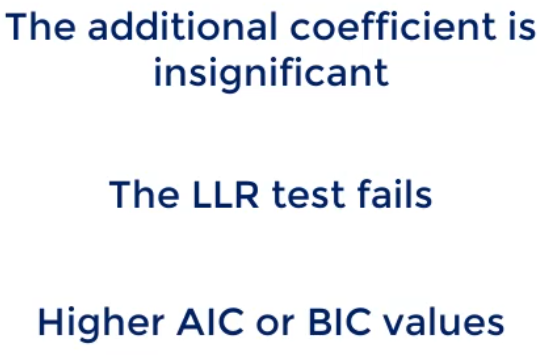

In [25]:
model_ret_ar_4 = ARMA(df.returns, order = (4,0))
results_ret_ar_4 = model_ret_ar_4.fit()
results_ret_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(4, 0)   Log Likelihood               -7901.330
Method:                       css-mle   S.D. of innovations              1.168
Date:                Sun, 10 May 2020   AIC                          15814.661
Time:                        10:59:50   BIC                          15853.788
Sample:                    01-10-1994   HQIC                         15828.371
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.015      1.267      0.205      -0.010       0.048
ar.L1.returns    -0.0245      0.014     -1.739      0.082      -0.052       0.003
ar.L2.returns    -0.0496      0.014     -3.531      0.000      -0.077      -0.022
ar.L3.returns    -0.0802      0.014     -5.701      0.000      -0.108      -0.053
ar.L4.returns     0.0464      0.014      3.291      0.001       0.019       0.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8888           -0.0000j            1.8888           -0.5000
AR.2            0.3231           -1.9331j            1.9599           -0.2236
AR.3            0.3231           +1.9331j            1.9599            0.2236
AR.4            2.9701           -0.0000j            2.9701           -0.0000
-----------------------------------------------------------------------------
"""

In [26]:
model_ret_ar_5 = ARMA(df.returns, order = (5,0))
results_ret_ar_5 = model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(5, 0)   Log Likelihood               -7892.390
Method:                       css-mle   S.D. of innovations              1.166
Date:                Sun, 10 May 2020   AIC                          15798.779
Time:                        11:00:07   BIC                          15844.428
Sample:                    01-10-1994   HQIC                         15814.775
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.348      0.178      -0.009       0.046
ar.L1.returns    -0.0217      0.014     -1.544      0.123      -0.049       0.006
ar.L2.returns    -0.0544      0.014     -3.865      0.000      -0.082      -0.027
ar.L3.returns    -0.0831      0.014     -5.914      0.000      -0.111      -0.056
ar.L4.returns     0.0449      0.014      3.190      0.001       0.017       0.073
ar.L5.returns    -0.0596      0.014     -4.232      0.000      -0.087      -0.032
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5481           -0.0000j            1.5481           -0.5000
AR.2           -0.2860           -1.7252j            1.7487           -0.2761
AR.3           -0.2860           +1.7252j            1.7487            0.2761
AR.4            1.4366           -1.2157j            1.8819           -0.1118
AR.5            1.4366           +1.2157j            1.8819            0.1118
-----------------------------------------------------------------------------
"""

In [27]:
model_ret_ar_6 = ARMA(df.returns, order = (6,0))
results_ret_ar_6 = model_ret_ar_6.fit()
results_ret_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sun, 10 May 2020   AIC                          15789.890
Time:                        11:00:18   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     -3.716      0.000      -0.080      -0.025
ar.L3.returns    -0.0870      0.014     -6.174      0.000      -0.115      -0.059
ar.L4.returns     0.0424      0.014      3.009      0.003       0.015       0.070
ar.L5.returns    -0.0607      0.014     -4.309      0.000      -0.088      -0.033
ar.L6.returns    -0.0466      0.014     -3.302      0.001      -0.074      -0.019
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2869           -0.9022j            1.5716           -0.0973
AR.2            1.2869           +0.9022j            1.5716            0.0973
AR.3           -0.0727           -1.5282j            1.5299           -0.2576
AR.4           -0.0727           +1.5282j            1.5299            0.2576
AR.5           -1.8659           -0.4836j            1.9275           -0.4596
AR.6           -1.8659           +0.4836j            1.9275            0.4596
-----------------------------------------------------------------------------
"""

In [28]:
model_ret_ar_7 = ARMA(df.returns, order = (7,0))
results_ret_ar_7 = model_ret_ar_7.fit()
results_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sun, 10 May 2020   AIC                          15791.294
Time:                        11:00:29   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.returns    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.returns     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.returns    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.returns    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.returns     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2270           -0.0000j            5.2270           -0.0000
-----------------------------------------------------------------------------
"""

In [29]:
LLR_test(model_ret_ar_6,model_ret_ar_7)

0.44

### Normalizing Values

In [34]:
benchmark = df.market_value.iloc[0]

In [35]:
df['norm'] = df.market_value.div(benchmark).mul(100)

In [36]:
sts.adfuller(df.norm)

(-1.892871013267244,
 0.33542220743300283,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

<b>Not stationary so we wouldnt run AR model</b>

In [38]:
benchmark = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(benchmark).mul(100)
sts.adfuller(df.norm_ret)

(-12.770265719497221,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

<b>-12.7 < -3.43 ==> The data is stationary</b>

### Normalized Returns

In [39]:
model_norm_ret_ar_1 = ARMA(df.norm_ret, order=(1,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood              -40351.743
Method:                       css-mle   S.D. of innovations            749.388
Date:                Sun, 10 May 2020   AIC                          80709.487
Time:                        11:13:28   BIC                          80729.050
Sample:                    01-10-1994   HQIC                         80716.342
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731     10.339     -1.158      0.247     -32.237       8.291
ar.L1.norm_ret    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4386           +0.0000j           43.4386            0.5000
-----------------------------------------------------------------------------
"""

In [40]:
model_norm_ret_ar_2 = ARMA(df.norm_ret, order=(2,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(2, 0)   Log Likelihood              -40345.450
Method:                       css-mle   S.D. of innovations            748.449
Date:                Sun, 10 May 2020   AIC                          80698.901
Time:                        11:14:50   BIC                          80724.985
Sample:                    01-10-1994   HQIC                         80708.041
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      9.834     -1.218      0.223     -31.247       7.301
ar.L1.norm_ret    -0.0242      0.014     -1.716      0.086      -0.052       0.003
ar.L2.norm_ret    -0.0500      0.014     -3.550      0.000      -0.078      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2417           -4.4635j            4.4701           -0.2586
AR.2           -0.2417           +4.4635j            4.4701            0.2586
-----------------------------------------------------------------------------
"""

In [41]:
model_norm_ret_ar_7 = ARMA(df.norm_ret, order=(7,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood              -40308.642
Method:                       css-mle   S.D. of innovations            742.977
Date:                Sun, 10 May 2020   AIC                          80635.283
Time:                        11:15:53   BIC                          80693.974
Sample:                    01-10-1994   HQIC                         80655.849
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9756      8.630     -1.388      0.165     -28.890       4.938
ar.L1.norm_ret    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.norm_ret    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.norm_ret    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.norm_ret     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.norm_ret    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.norm_ret    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.norm_ret     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2268           -0.0000j            5.2268           -0.0000
-----------------------------------------------------------------------------
"""

As we can see normalizing the data didnt change p-val, it changed only the constants

### Analysing the Residuals

In [50]:
model_ar_7 = ARMA(df.market_value, order = (7,0))
results_ar_7 = model_ar_7.fit()
results_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood              -27586.899
Method:                       css-mle   S.D. of innovations             58.902
Date:                Sun, 10 May 2020   AIC                          55191.797
Time:                        11:24:11   BIC                          55250.488
Sample:                    01-10-1994   HQIC                         55212.363
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.9686    590.446      8.621      0.000    3932.716    6247.221
ar.L1.market_value     0.9786      0.014     69.510      0.000       0.951       1.006
ar.L2.market_value    -0.0304      0.020     -1.540      0.124      -0.069       0.008
ar.L3.market_value    -0.0267      0.020     -1.353      0.176      -0.065       0.012
ar.L4.market_value     0.1039      0.020      5.279      0.000       0.065       0.142
ar.L5.market_value    -0.0668      0.020     -3.386      0.001      -0.105      -0.028
ar.L6.market_value    -0.0025      0.020     -0.127      0.899      -0.041       0.036
ar.L7.market_value     0.0427      0.014      3.025      0.002       0.015       0.070
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2            1.3301           -0.9297j            1.6228           -0.0971
AR.3            1.3301           +0.9297j            1.6228            0.0971
AR.4           -0.0400           -1.5870j            1.5875           -0.2540
AR.5           -0.0400           +1.5870j            1.5875            0.2540
AR.6           -1.7613           -0.6516j            1.8780           -0.4436
AR.7           -1.7613           +0.6516j            1.8780            0.4436
-----------------------------------------------------------------------------
"""

In [51]:
df['res_price'] = results_ar_7.resid #contains the errors for prices

In [52]:
print(f'mean: {df.res_price.mean()}')
print(f'var: {df.res_price.var()}')

mean: 0.3525547860527502
var: 4010.48394647191


mean close to zero which suggest that on average our model performs well

but the variance is high, its because AR models work poorly on no-stationary data

In [53]:
sts.adfuller(df.res_price)

(-75.96947805112163,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 54832.42171867285)

p-val = 0 ==> its suggests stationarity

Text(0.5, 1.0, 'ACF of Residuals for prices')

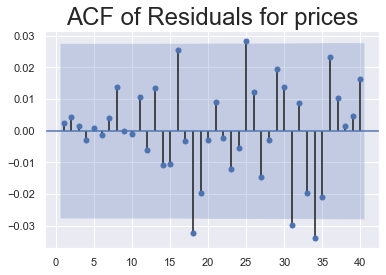

In [54]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF of Residuals for Prices", size = 24)

most of errors looks like white noise (its good)

BUT we can see few lines outside the insignificant place which means we may find better model

Text(0.5, 1.0, 'Residuals of Prices')

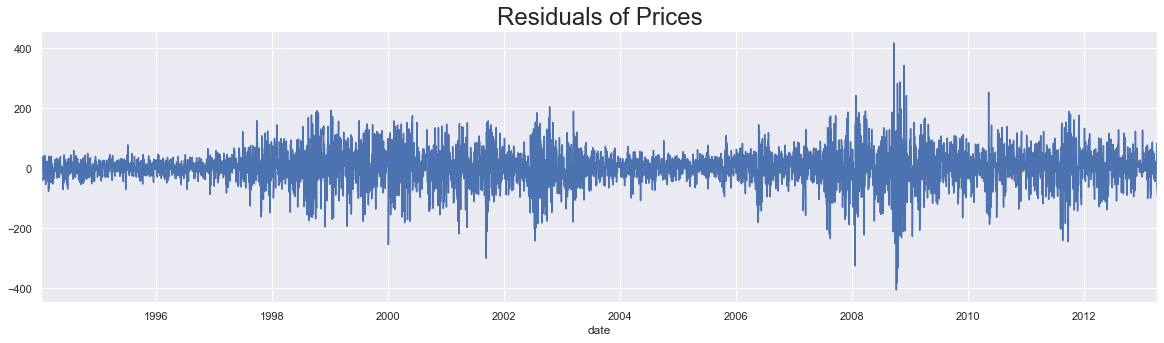

In [55]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)

### Analysing the Residuals of Returns

In [57]:
df['res_ret'] = results_ret_ar_6.resid #contains the errors for prices
print(f'mean: {df.res_ret.mean()}')
print(f'var: {df.res_ret.var()}')

mean: -5.372866189065254e-05
var: 1.3559802110731467


mean close to zero and var isnt so big ==> The model feels preety good

In [58]:
sts.adfuller(df.res_ret)

(-70.7838002082164,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15692.5708336649)

Text(0.5, 1.0, 'ACF of Residuals for Returns')

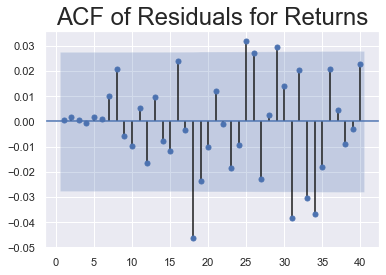

In [61]:
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size = 24)

Most of coefficients is not significant hence our model is a good predictor but it feels that we can find better one

Text(0.5, 1.0, 'Residuals of Returns')

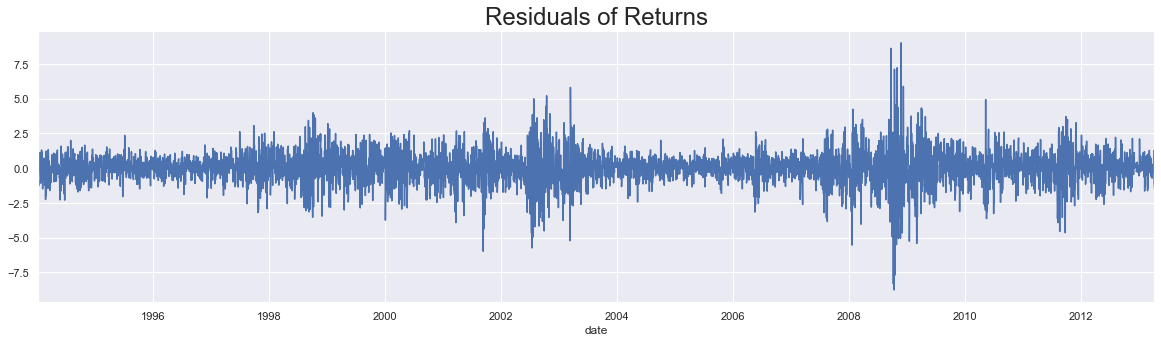

In [60]:
df.res_ret[1:].plot(figsize=(20,5))
plt.title("Residuals of Returns",size=24)

<b>Residuals = Errors</b>

* as we can see the errors jumps on 2009